In [99]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [100]:
directory = './data/'

In [101]:
# Cargar los datos
df_marca = pd.read_csv(directory + "df_marca.csv")
df_tiendas = pd.read_csv(directory + "df_tiendas.csv")
df_clima = pd.read_csv(directory + "df_clima.csv")
df_transacciones = pd.read_csv(directory + "df_transacciones.csv")
df_transacciones_detalle = pd.read_csv(directory + "df_transacciones_detalle.csv")

In [102]:
print("Cantidad de nulos en marca\n",df_marca.isnull().sum(),'\n\n')
print("Cantidad de nulos en tiendas\n",df_tiendas.isnull().sum(),'\n\n')
print("Cantidad de nulos en clima\n",df_clima.isnull().sum(),'\n\n')
print("Cantidad de nulos en transacciones\n",df_transacciones.isnull().sum(),'\n\n')
print("Cantidad de nulos en detalle de transacciones\n",df_transacciones_detalle.isnull().sum())

Cantidad de nulos en marca
 id_empresa    0
marca         0
dtype: int64 


Cantidad de nulos en tiendas
 id_tienda    0
distrito     3
region       1
dtype: int64 


Cantidad de nulos en clima
 fecha       0
temp_min    0
temp_max    0
dtype: int64 


Cantidad de nulos en transacciones
 id_empresa                0
id_tienda                 0
id_transaccion            0
fecha_transaccion         0
id_cliente           150361
monto_delivery            0
dtype: int64 


Cantidad de nulos en detalle de transacciones
 id_empresa                0
id_transaccion            0
id_detalle_transaccion    0
id_producto               0
categoria_producto        0
precio_unitario           0
cantidad                  0
dtype: int64


In [103]:
# Usar como tabla principal df_transacciones para cruzar la información y ver si existen nulos

df_cruce_detalle = pd.merge(df_transacciones, df_transacciones_detalle, on='id_transaccion', how='left')
df_cruce_tienda = pd.merge(df_transacciones, df_tiendas, on='id_tienda', how='left')
df_cruce_marca = pd.merge(df_transacciones, df_marca, on='id_empresa', how='left')

# Transformar en Date las columnas de fecha
df_transacciones['fecha_transaccion'] = pd.to_datetime(df_transacciones['fecha_transaccion'])
df_clima['fecha'] = pd.to_datetime(df_clima['fecha'])

# Crear columna fecha sin hora para cruzar la información
df_transacciones['fecha'] = pd.to_datetime(df_transacciones['fecha_transaccion'].dt.date)
df_transacciones['mes'] = df_transacciones['fecha'].dt.month

# Ahora sí cruzar df_transacciones vs df_clima
df_cruce_clima = pd.merge(df_transacciones, df_clima, on='fecha')

df_cruce_detalle = df_cruce_detalle.drop('id_empresa_y', axis=1)
df_cruce_detalle = df_cruce_detalle.rename(columns={'id_empresa_x':'id_empresa'})

print("Cantidad de nulos vs transacciones detalle\n",df_cruce_detalle.isnull().sum(),'\n\n')
print("Cantidad de nulos vs tienda\n",df_cruce_tienda.isnull().sum(),'\n\n')
print("Cantidad de nulos en marca\n",df_cruce_marca.isnull().sum(),'\n\n')
print("Cantidad de nulos vs clima\n",df_cruce_clima.isnull().sum())

Cantidad de nulos vs transacciones detalle
 id_empresa                     0
id_tienda                      0
id_transaccion                 0
fecha_transaccion              0
id_cliente                150361
monto_delivery                 0
id_detalle_transaccion    176056
id_producto               176056
categoria_producto        176056
precio_unitario           176056
cantidad                  176056
dtype: int64 


Cantidad de nulos vs tienda
 id_empresa                0
id_tienda                 0
id_transaccion            0
fecha_transaccion         0
id_cliente           150361
monto_delivery            0
distrito                  0
region                    0
dtype: int64 


Cantidad de nulos en marca
 id_empresa                0
id_tienda                 0
id_transaccion            0
fecha_transaccion         0
id_cliente           150361
monto_delivery            0
marca                     0
dtype: int64 


Cantidad de nulos vs clima
 id_empresa                0
id_tienda   

          marca  transacciones perdidas
0  hamburguesas                   77417
1        pizzas                   91156
2   pollo frito                    7483


<Figure size 2000x1400 with 0 Axes>

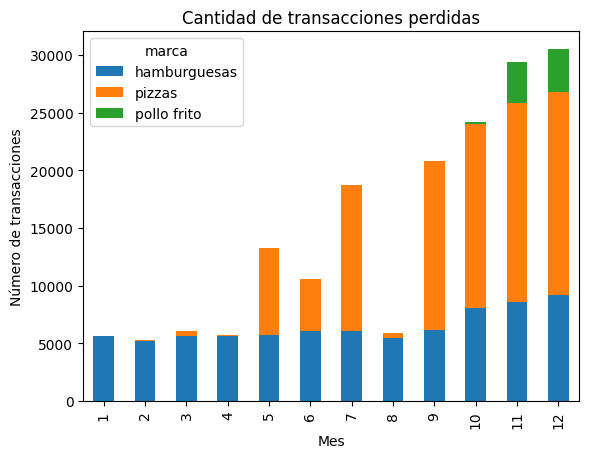

In [105]:
# Crear un gráfico de transacción mensual por marca y nulos
df_cruce_detalle = pd.merge(df_transacciones, df_transacciones_detalle, on='id_transaccion', how='left')
df_cruce_tienda = pd.merge(df_transacciones, df_tiendas, on='id_tienda', how='left')
df_cruce_marca = pd.merge(df_transacciones, df_marca, on='id_empresa', how='left')

# Transformar en Date las columnas de fecha
df_transacciones['fecha_transaccion'] = pd.to_datetime(df_transacciones['fecha_transaccion'])
df_clima['fecha'] = pd.to_datetime(df_clima['fecha'])

# Crear columna fecha sin hora para cruzar la información
df_transacciones['fecha'] = pd.to_datetime(df_transacciones['fecha_transaccion'].dt.date)
df_transacciones['mes'] = df_transacciones['fecha'].dt.month

# Ahora sí cruzar df_transacciones vs df_clima
df_cruce_clima = pd.merge(df_transacciones, df_clima, on='fecha')

df_cruce_detalle = df_cruce_detalle.drop('id_empresa_y', axis=1)
df_cruce_detalle = df_cruce_detalle.rename(columns={'id_empresa_x':'id_empresa'})

# Primero un DF con solo datos nulos (perdidos)
df_cruce_detalle = pd.merge(df_cruce_detalle, df_marca, on='id_empresa')
df_cruce_detalle = df_cruce_detalle.loc[df_cruce_detalle['id_detalle_transaccion'].isnull()]

# Resumen de transacciones totales perdidas por marca
df_perdidos = df_cruce_detalle.groupby(['marca']).size().reset_index(name='transacciones perdidas')
print(df_perdidos)

df_agrupado = df_cruce_detalle.groupby(['mes', 'marca']).size().reset_index(name='transacciones perdidas')

plt.figure(figsize=(20, 14))

# Crea el gráfico de barras apiladas
df_agrupado.pivot(index='mes', columns='marca', values='transacciones perdidas').plot(kind='bar', stacked=True)

# Título y etiquetas a los ejes
plt.title('Cantidad de transacciones perdidas')
plt.xlabel('Mes')
plt.ylabel('Número de transacciones')
plt.show()

# ANÁLISIS EN FUNCIÓN DE LAS TRANSACCIONES

In [106]:
# Unir los datos para tener toda la información en un solo DataFrame sin incluir df_transacciones_detalle
df = pd.merge(df_transacciones, df_tiendas, on='id_tienda')
df = pd.merge(df, df_marca, on='id_empresa') 
df = pd.merge(df, df_clima, on='fecha')

df['dia'] = df['fecha'].dt.dayofweek
df['temp_avg'] = (df['temp_min'] + df['temp_max']) / 2

df.head(5)

,id_empresa,id_tienda,id_transaccion,fecha_transaccion,id_cliente,monto_delivery,fecha,mes,distrito,region,marca,temp_min,temp_max,dia,temp_avg
0,4,4-5127,282873,2022-01-01 12:13:57,22010.0,4.9,2022-01-01,1,Santiago de Surco,Lima,pollo frito,19,24,5,21.5
1,4,4-5127,282904,2022-01-01 13:04:22,2611.0,4.9,2022-01-01,1,Santiago de Surco,Lima,pollo frito,19,24,5,21.5
2,4,4-5127,282911,2022-01-01 13:22:47,140391.0,4.9,2022-01-01,1,Santiago de Surco,Lima,pollo frito,19,24,5,21.5
3,4,4-5127,282980,2022-01-01 16:00:17,285033.0,4.9,2022-01-01,1,Santiago de Surco,Lima,pollo frito,19,24,5,21.5
4,4,4-5127,282999,2022-01-01 16:38:48,288009.0,4.9,2022-01-01,1,Santiago de Surco,Lima,pollo frito,19,24,5,21.5


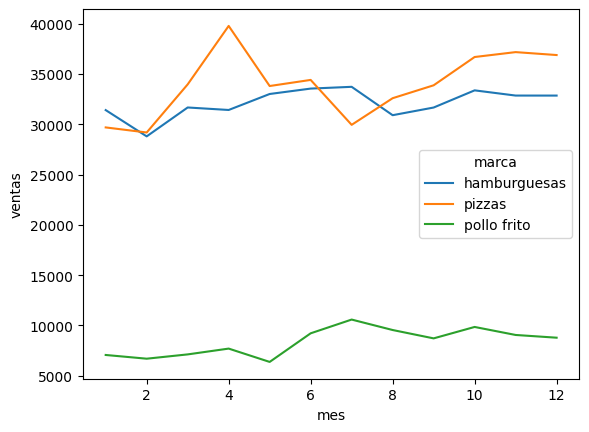

In [107]:
# Análisis descriptivo
grouped = df.groupby(['mes', 'marca'], as_index=False).agg({'id_transaccion': 'count'})
grouped = grouped.rename(columns={'id_transaccion': 'ventas'})

# Graficar la evolución de las ventas por fecha y marca
sns.lineplot(x='mes', y='ventas', hue='marca', data=grouped)
plt.show()

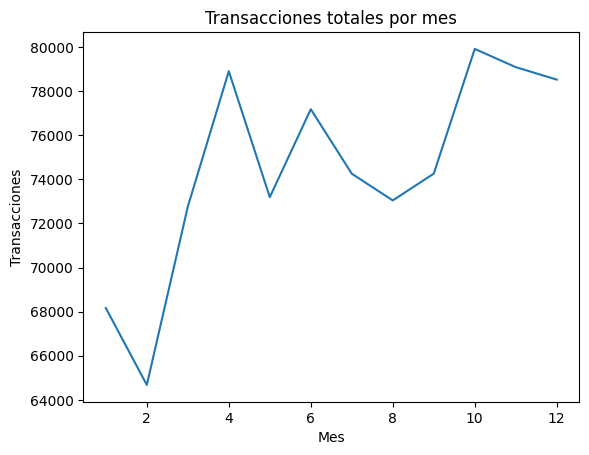

In [108]:
df_grouped = df.groupby(['mes']).size().reset_index(name='transacciones')

plt.plot(df_grouped['mes'], df_grouped['transacciones'])
plt.xlabel('Mes')
plt.ylabel('Transacciones')
plt.title('Transacciones totales por mes')
plt.show()

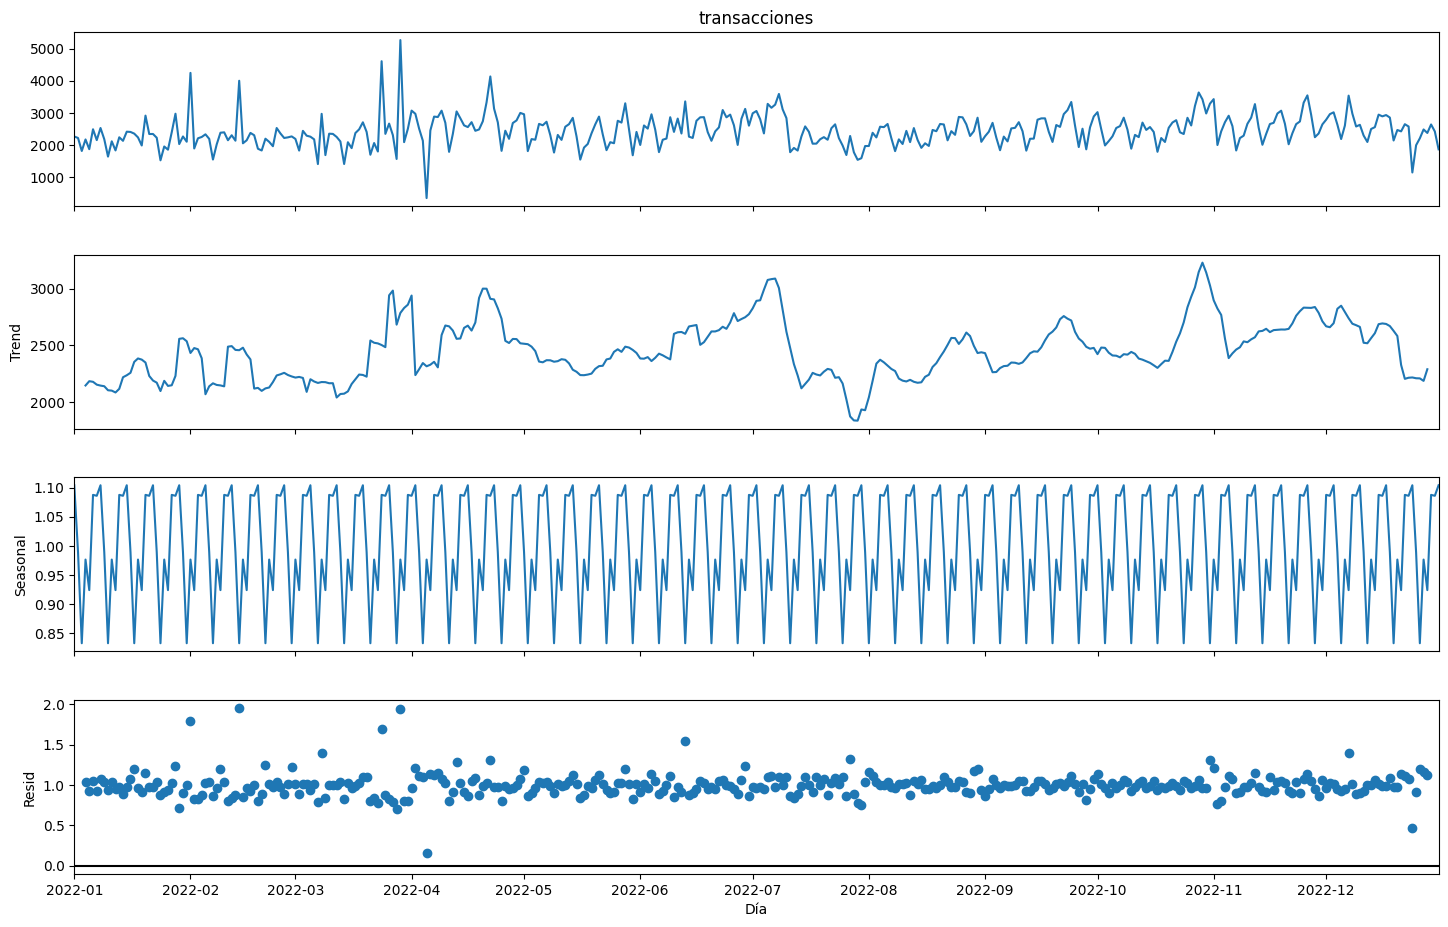

In [109]:
# ANÁLISIS DE TENDENCIA

df_fecha = df.groupby(['fecha'], as_index=False).agg({'id_transaccion': 'count'})
df_fecha = df_fecha.rename(columns={'id_transaccion': 'transacciones'})
df_fecha = df_fecha.set_index('fecha')

# Descomposición de la serie temporal
result = seasonal_decompose(df_fecha['transacciones'], model='multiplicative')
# Gráfico de la descomposición
result.plot()
plt.xlabel('Día')
# Forzar el tamaño de la figura después de result.plot()
plt.gcf().set_size_inches(16, 10)
plt.show()

In [110]:
# MARCAS
df_fecha_marca = df.groupby(['fecha','marca'], as_index=False).agg({'id_transaccion': 'count'})
df_fecha_marca = df_fecha_marca.rename(columns={'id_transaccion': 'transacciones'})


# HAMBURGUESAS
df_fecha_hamburguesas = df_fecha_marca[df_fecha_marca['marca'] == 'hamburguesas']
df_fecha_hamburguesas  = df_fecha_hamburguesas.set_index('fecha')

# PIZZAS
df_fecha_pizzas = df_fecha_marca[df_fecha_marca['marca'] == 'pizzas']
df_fecha_pizzas  = df_fecha_pizzas.set_index('fecha')

# POLLO FRITO
df_fecha_pollofrito = df_fecha_marca[df_fecha_marca['marca'] == 'pollo frito']
df_fecha_pollofrito  = df_fecha_pollofrito.set_index('fecha')

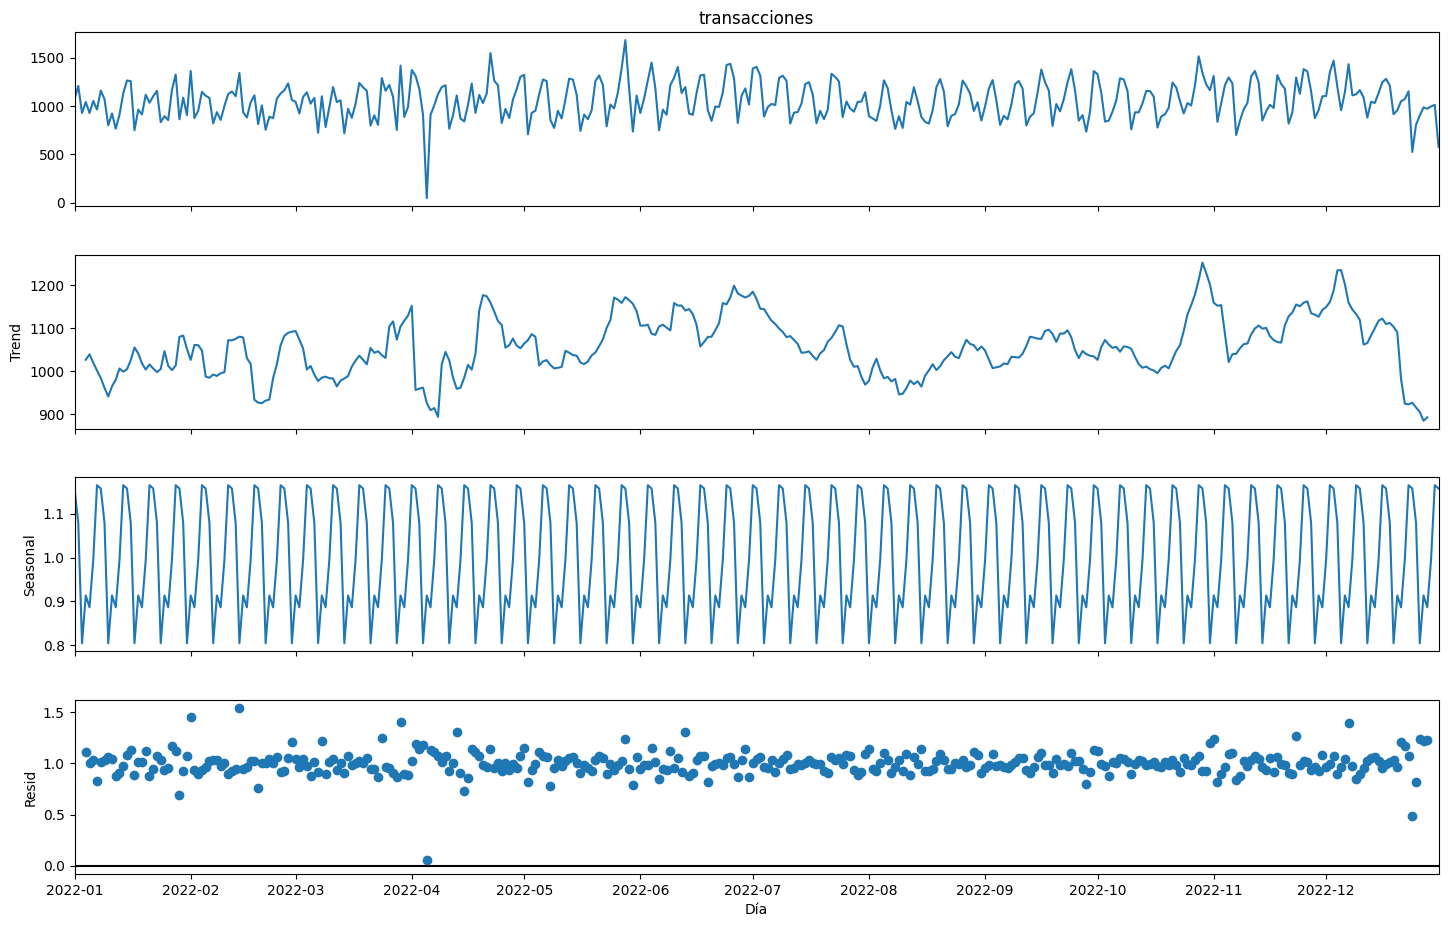

In [111]:
# Descomposición de la serie temporal HAMBURGUESAS
result = seasonal_decompose(df_fecha_hamburguesas['transacciones'], model='multiplicative')
# Gráfico de la descomposición
result.plot()
plt.xlabel('Día')
# Forzar el tamaño de la figura después de result.plot()
plt.gcf().set_size_inches(16, 10)
plt.show()

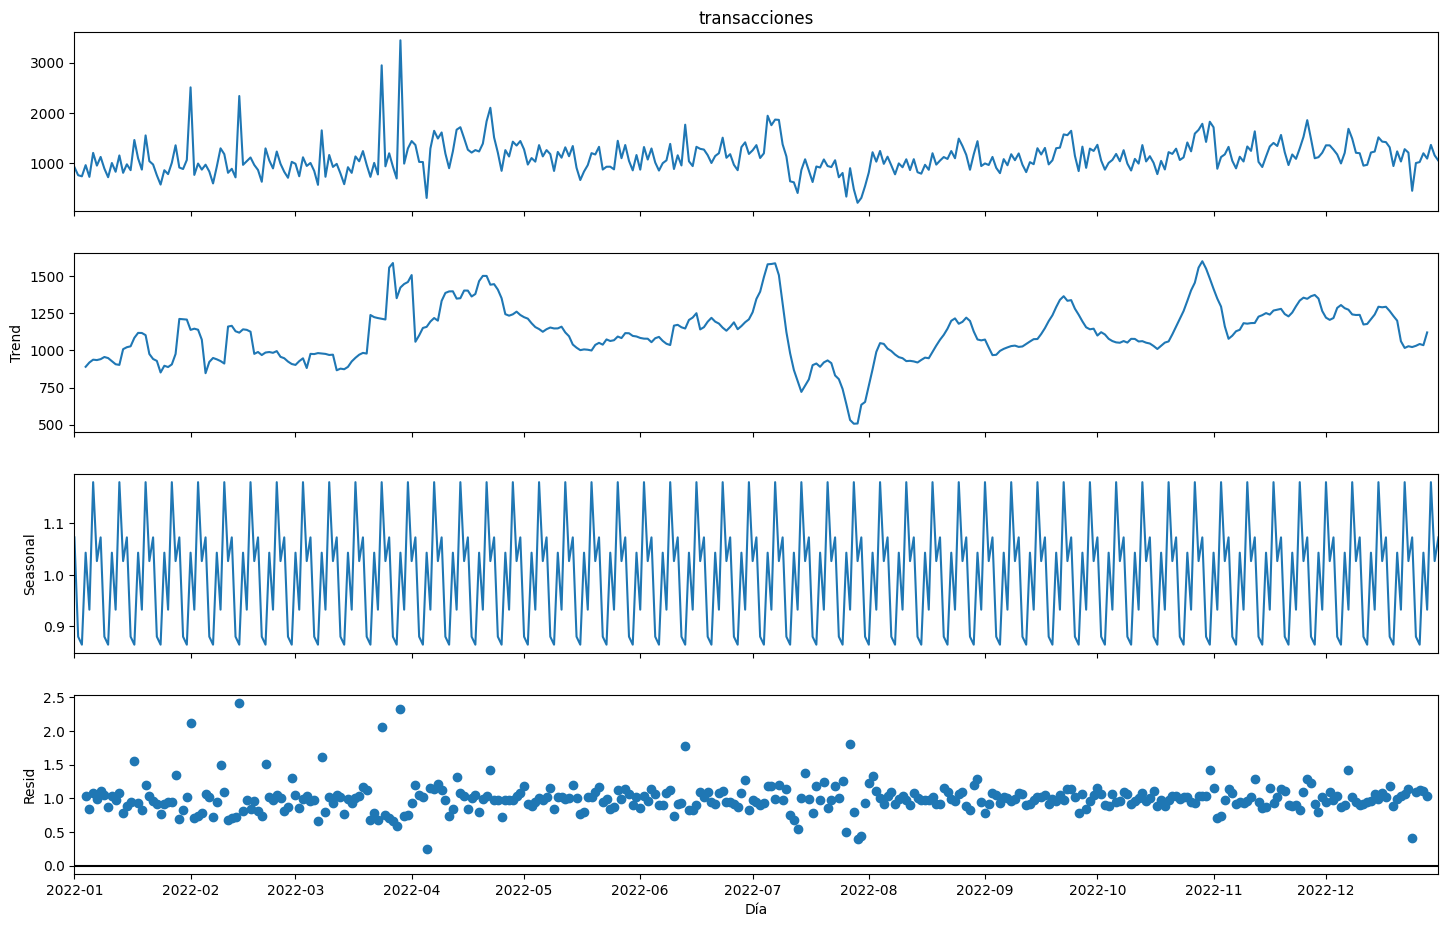

In [112]:
# Descomposición de la serie temporal PIZZAS
result = seasonal_decompose(df_fecha_pizzas['transacciones'], model='multiplicative')
# Gráfico de la descomposición
result.plot()
plt.xlabel('Día')
# Forzar el tamaño de la figura después de result.plot()
plt.gcf().set_size_inches(16, 10)
plt.show()

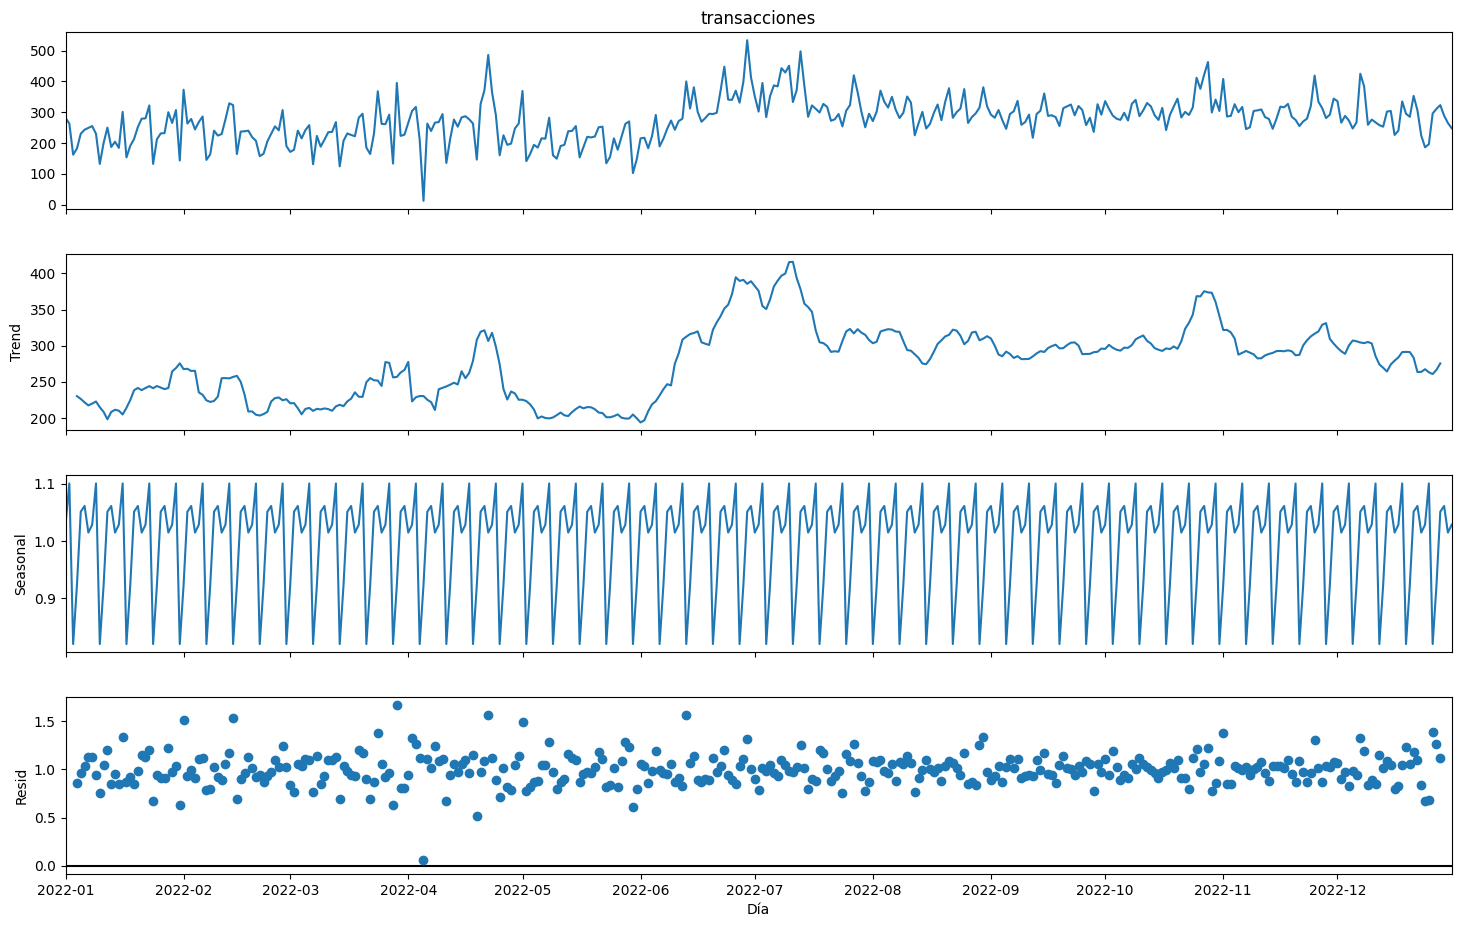

In [113]:
# Descomposición de la serie temporal POLLO FRITO
result = seasonal_decompose(df_fecha_pollofrito['transacciones'], model='multiplicative')
# Gráfico de la descomposición
result.plot()
plt.xlabel('Día')
# Forzar el tamaño de la figura después de result.plot()
plt.gcf().set_size_inches(16, 10)
plt.show()

<Figure size 1600x800 with 0 Axes>

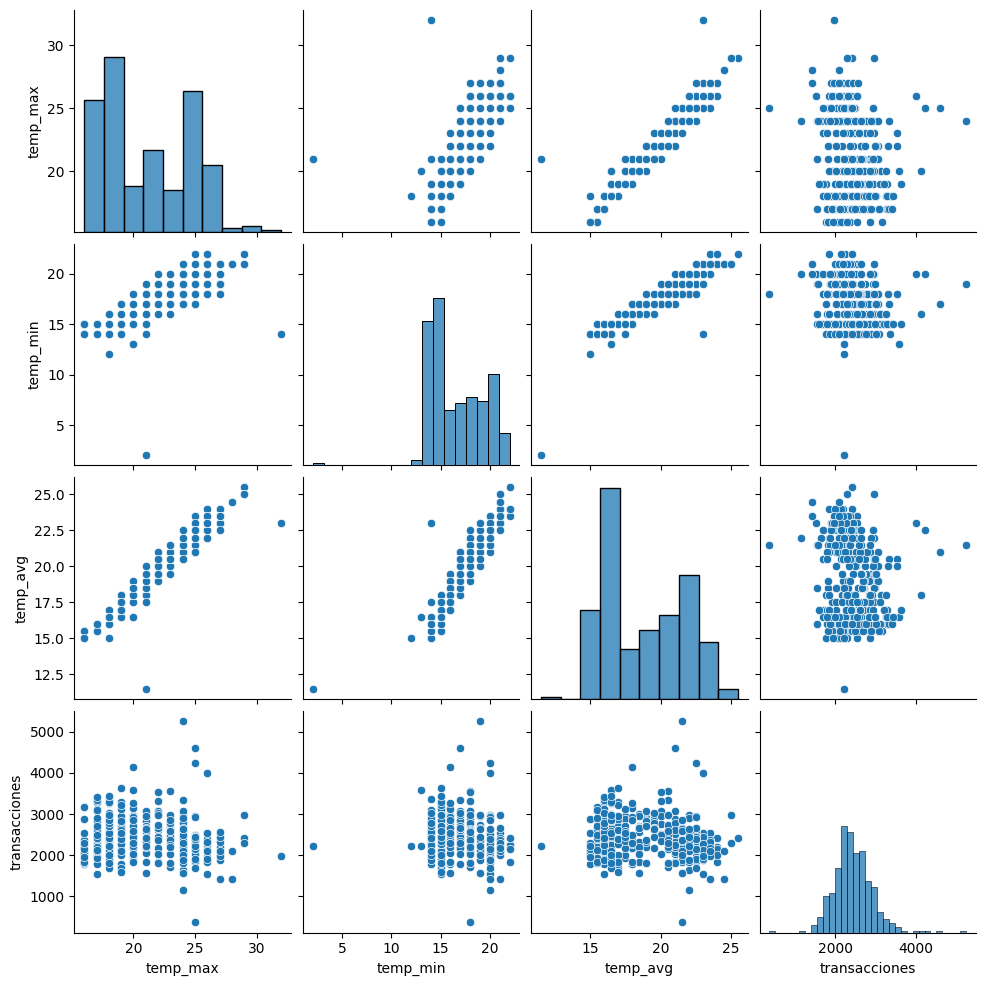

In [114]:
df_corr_temp = df.groupby(['fecha','temp_max','temp_min','temp_avg'], as_index=False).agg({'id_transaccion': 'count'})
df_corr_temp = df_corr_temp.rename(columns={'id_transaccion': 'transacciones'})
plt.figure(figsize=(16, 8))
sns.pairplot(df_corr_temp)
plt.show()

In [115]:
# Arreglando variables para ejecutar modelo
df = pd.get_dummies(df, columns=['marca','region'])
df['delivery_flag'] = df['monto_delivery'].apply(lambda x: 0 if x == 0 else 1)

In [116]:
df_reg = df.groupby(['fecha','temp_avg','marca_hamburguesas', 'marca_pizzas',
       'marca_pollo frito', 'region_Arequipa', 'region_Callao',
       'region_Chiclayo', 'region_Cusco', 'region_Huancayo', 'region_Ica',
       'region_Lima', 'region_Piura', 'region_San Román', 'region_Trujillo','delivery_flag'], as_index=False).agg({'id_transaccion': 'count'})
df_reg = df_reg.rename(columns={'id_transaccion': 'transacciones'})

### RANDOM FOREST

In [117]:

# MODELO DE REGRESIÓN RANDOM FOREST

# Selecciona las variables relevantes
X = df_reg[['temp_avg','marca_hamburguesas', 'marca_pizzas',
       'marca_pollo frito','region_Lima','delivery_flag']]

y = df_reg['transacciones']

# Separa el dataset en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# Entrena un modelo de Random Forest Regressor
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)

# Hace predicciones sobre los datos de prueba
y_pred = regr.predict(X_test)

# Evalúa la calidad de las predicciones
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('RMSE:', rmse)
print('R2:', r2)

MSE: 15083.122239793624
RMSE: 122.81336344141717
R2: 0.8287300682159218


Variable importances:
1. feature 4 (0.638763)
2. feature 3 (0.221820)
3. feature 2 (0.039937)
4. feature 1 (0.038722)
5. feature 0 (0.036104)
6. feature 5 (0.024655)


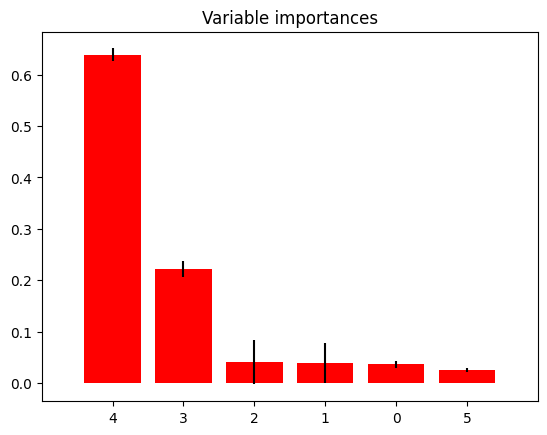

In [118]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Imprime la importancia de cada variable
print("Variable importances:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Grafica la importancia de las variables
plt.figure()
plt.title("Variable importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [119]:
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print('Variable:', X.columns[indices[f]])

Feature ranking:
1. feature 4 (0.638763)
Variable: region_Lima
2. feature 3 (0.221820)
Variable: marca_pollo frito
3. feature 2 (0.039937)
Variable: marca_pizzas
4. feature 1 (0.038722)
Variable: marca_hamburguesas
5. feature 0 (0.036104)
Variable: temp_avg
6. feature 5 (0.024655)
Variable: delivery_flag


In [120]:
# MODELO DE REGRESIÓN LINEAL
# Preparar los datos para el modelo
X = df_reg[['temp_avg','marca_hamburguesas', 'marca_pizzas',
       'marca_pollo frito',
       'region_Chiclayo', 'region_Cusco', 'region_Huancayo', 'region_Ica',
       'region_Lima', 'region_Piura','delivery_flag']]

y = df_reg['transacciones']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Crear una instancia de un modelo de regresión lineal
reg = LinearRegression()

# Entrenar el modelo
reg.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba
y_pred = reg.predict(X_test)


# Crear una instancia de un modelo de regresión lineal
model = sm.OLS(y, X)
results = model.fit()

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

r2 = r2_score(y_test, y_pred)
print("R2:", r2)


print(results.summary())

RMSE: 157.12340674363114
R2: 0.6496376505404455
                            OLS Regression Results                            
Dep. Variable:          transacciones   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     1187.
Date:                Thu, 14 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:32:39   Log-Likelihood:                -41324.
No. Observations:                6334   AIC:                         8.267e+04
Df Residuals:                    6323   BIC:                         8.274e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [121]:
# REGRESIÓN - ¿Existe influencia en el comportamiento de las ventas de una marca sobre las otras?

# Preparar los datos para el modelo
X = df_reg[['marca_hamburguesas', 'marca_pizzas', 'marca_pollo frito']]
y = df_reg['transacciones']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Crear una instancia de un modelo de regresión lineal
reg = LinearRegression()

# Entrenar el modelo
reg.fit(X_train, y_train)

# Hacer predicciones en los datos de prueba
y_pred = reg.predict(X_test)

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse)
print("R2:", r2)

# Imprimir los coeficientes
print("Coeficientes:")
print(reg.intercept_)
print(reg.coef_)

RMSE: 272.1027255500684
R2: 0.0625800009285834
Coeficientes:
1279274259981975.8
[-1.27927426e+15 -1.27927426e+15 -1.27927426e+15]


### CONCLUSIONES

- Usando el modelo de Random Forest obtenemos un RMSE de 120, el cual es un valor aceptable para las posibles predicciones.